In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Data-Analysis-Projects/Credit_Card_Fraud_Detection')
print(os.getcwd())

/content/drive/My Drive/Colab Notebooks/Data-Analysis-Projects/Credit_Card_Fraud_Detection


In [3]:
!pip install catboost

     |████████████████████████████████| 64.4MB 44kB/s 


 ## Importing Libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
classification_report, confusion_matrix, precision_recall_curve, \
average_precision_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost as xgb
from catboost import CatBoostClassifier

In [0]:
# Custom Functions
import curves as C

In [0]:
dataset = pd.read_csv('creditcard.csv')
dataset_X = dataset.drop(['Class'], axis = 1)
dataset_y = dataset['Class']

 ## Splitting the dataset into the Training set and Test set

In [0]:
def split_data(X, y):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 0)
    print('train-set size: ', len(y_train), 
          '\ntest-set size: ', len(y_test))    
    print('fraud cases in train-set', sum(y_train),
          '\nfraud cases in test-set: ', sum(y_test))
    return X_train, X_test, y_train, y_test

 ## Define function to get predictions

In [0]:
def get_predictions(y_true, y_pred): 
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, cmap = "coolwarm", annot = True, linewidths = 0.5)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted class")
    plt.ylabel("Real class")
    plt.show()
    print('==============================')
    print(cm)
    print('==============================')
    print('accuracy = {}'.format(accuracy_score(y_true, y_pred)))
    print('precision = {}'.format(precision_score(y_true, y_pred)))
    print('recall = {}'.format(recall_score(y_true, y_pred)))
    print('f1 score = {}'.format(f1_score(y_true, y_pred)))
    print('==============================')
    print(classification_report(y_true, y_pred))

 ## Feature importance plot

In [0]:
def plot_feature_importance(model, predictors):
    tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': model.feature_importances_})
    tmp = tmp.sort_values(by = 'Feature importance', ascending = False)
    plt.figure(figsize = (12, 6))
    plt.title('Features importance', fontsize = 14)
    s = sns.barplot(x = 'Feature', y = 'Feature importance', data = tmp)
    s.set_xticklabels(s.get_xticklabels(), rotation = 45)
    plt.show()

 ## Case 1: Drop 'Time', 'Amount'

In [10]:
drop_list = ['Time', 'Amount']
# drop_list = ['Time', 'Amount', 'V28', 'V27', 'V26', 'V25', 'V24', 'V23', 'V22', 'V20', 'V15', 'V13', 'V8']

X = dataset_X.drop(drop_list, axis = 1)
predictor_name = X.columns
X = X.values
y = dataset_y.values
print(predictor_name)
X_train, X_test, y_train, y_test = split_data(X, y)

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'],
      dtype='object')
train-set size:  199364 
test-set size:  85443
fraud cases in train-set 344 
fraud cases in test-set:  148


## 1. Logistic Regression

 ### 1.1 Logistic Regression - Without hyperparameters tuning

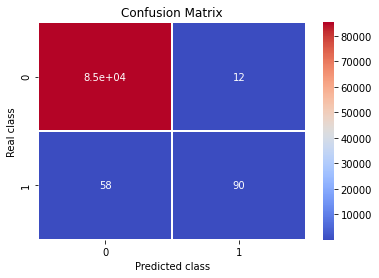

[[85283    12]
 [   58    90]]
accuracy = 0.9991807403766253
precision = 0.8823529411764706
recall = 0.6081081081081081
f1 score = 0.72
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.88      0.61      0.72       148

    accuracy                           1.00     85443
   macro avg       0.94      0.80      0.86     85443
weighted avg       1.00      1.00      1.00     85443



In [0]:
lr_clf = LogisticRegression(solver = 'liblinear', random_state = 0)
lr_clf.fit(X_train, y_train)
y_score = lr_clf.predict_proba(X_test)[:, 1]
y_pred = lr_clf.predict(X_test)
get_predictions(y_true = y_test, y_pred = y_pred)

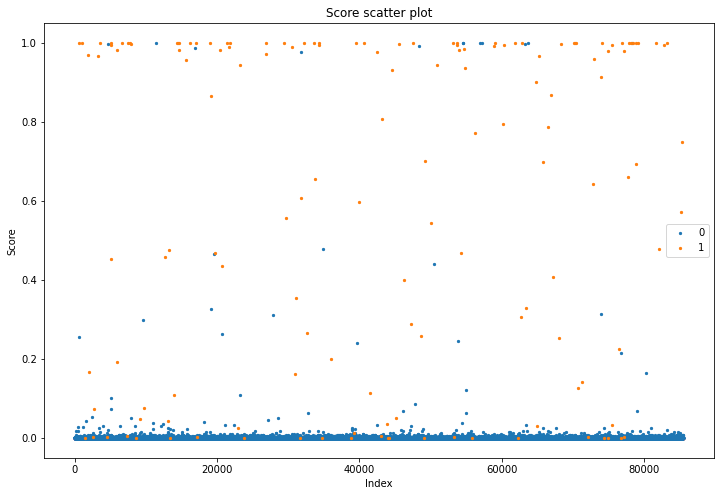

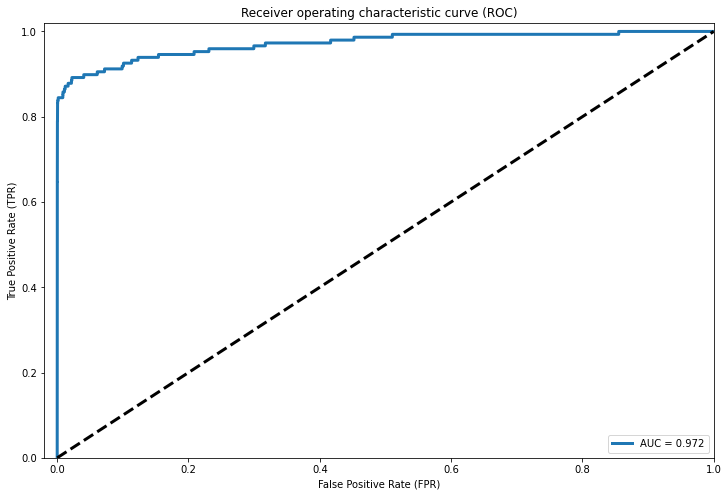

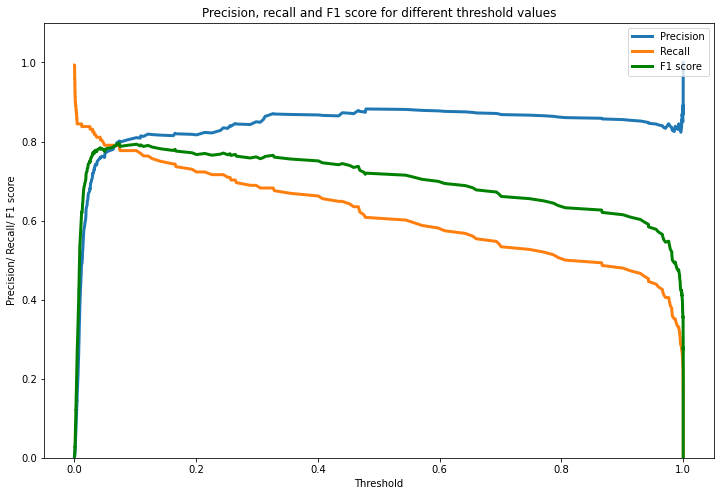

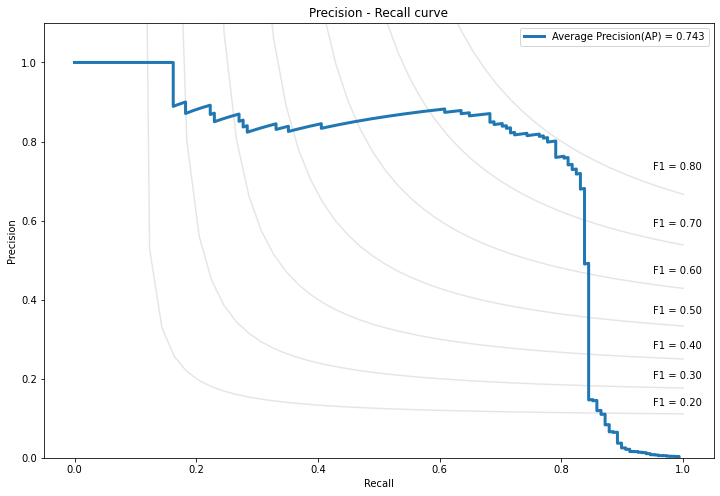

In [0]:
# ## Plot scores, ROC, Precision, Recall, F1 curve, Precision-Recall curve
C.plot_scores(y_true = y_test, y_score = y_score)
fpr_lr, tpr_lr, roc_auc_lr = C.plot_ROC(y_true = y_test, y_score = y_score)
precision_lr, recall_lr, threshold_lr, f1_scores_lr = C.plot_precision_recall_vs_threshold(y_true = y_test, y_score = y_score)
_, _, pr_auc_lr = C.plot_precision_recall(y_true = y_test, y_score = y_score)

### 1.2 Grid Search CV to optimise 'average_precision'

In [0]:
# Applying Grid Search to find the best model and the best parameters
classifier = LogisticRegression(solver = 'liblinear', random_state = 0)
parameter = [{'penalty': ['l1'], 'C': [0.01, 0.1, 1, 10]}, 
             {'penalty': ['l2'], 'C': [0.01, 0.1, 1, 10]}]

skf = StratifiedKFold(n_splits = 5, random_state = 0)
grid_search = GridSearchCV(estimator = classifier, 
                           param_grid = parameter,
                           scoring = 'f1',
                           cv = skf.split(X_train, y_train),
                           n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)
best_score = grid_search.best_score_
best_parameters = grid_search.best_params_
results = grid_search.cv_results_
best_parameters

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


{'C': 1, 'penalty': 'l1'}

### 1.3 Logistic Regression with best parameters

In [0]:
best_parameters['C']

1

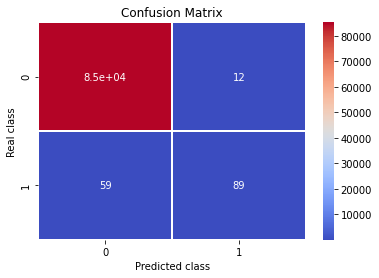

[[85283    12]
 [   59    89]]
accuracy = 0.99916903666772
precision = 0.8811881188118812
recall = 0.6013513513513513
f1 score = 0.714859437751004
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.88      0.60      0.71       148

    accuracy                           1.00     85443
   macro avg       0.94      0.80      0.86     85443
weighted avg       1.00      1.00      1.00     85443



In [11]:
lr_clf = LogisticRegression(C = 0.1, penalty = 'l2', 
                            solver = 'liblinear', random_state = 0)
lr_clf.fit(X_train, y_train)
y_score = lr_clf.predict_proba(X_test)[:, 1]
y_pred = lr_clf.predict(X_test)
get_predictions(y_true = y_test, y_pred = y_pred)

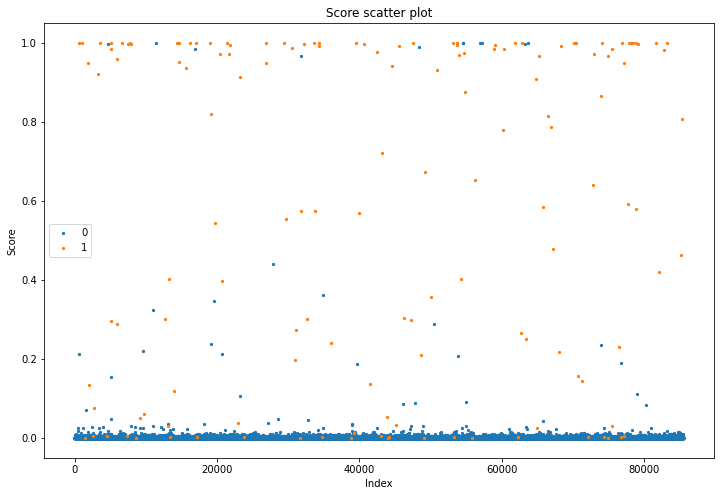

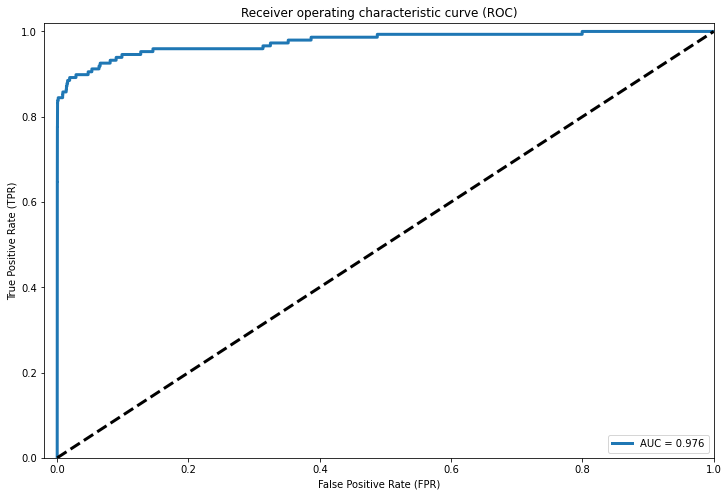

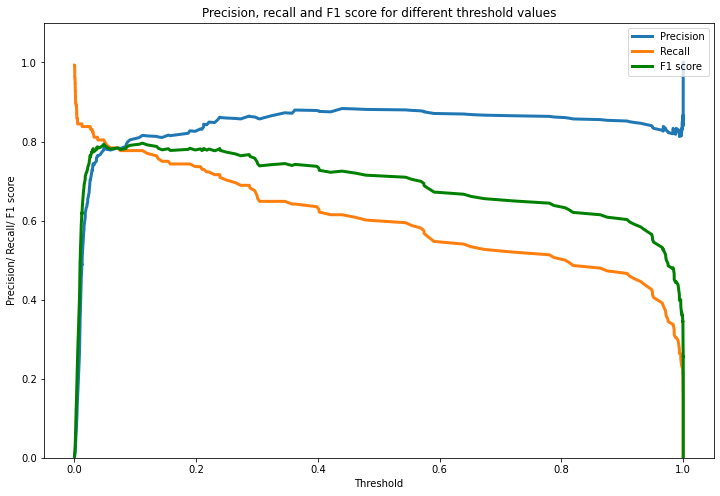

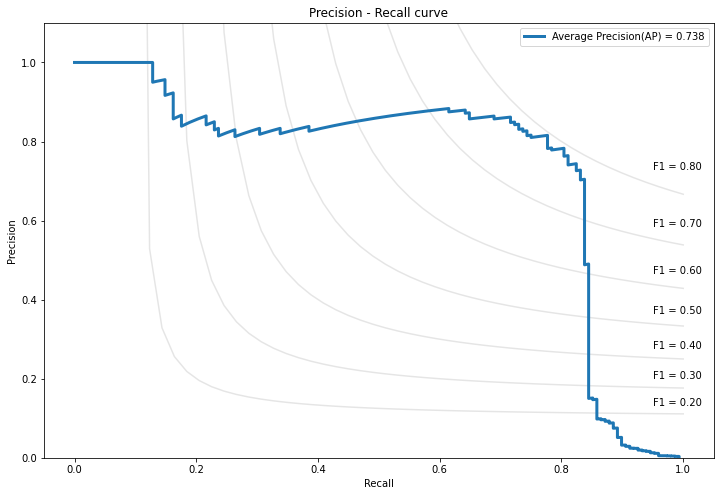

In [12]:
# ## Plot scores, ROC, Precision, Recall, F1 curve, Precision-Recall curve
C.plot_scores(y_true = y_test, y_score = y_score)
fpr_lr, tpr_lr, roc_auc_lr = C.plot_ROC(y_true = y_test, y_score = y_score)
precision_lr, recall_lr, threshold_lr, f1_scores_lr = C.plot_precision_recall_vs_threshold(y_true = y_test, y_score = y_score)
_, _, pr_auc_lr = C.plot_precision_recall(y_true = y_test, y_score = y_score)

 ##  2. Extreme Gradient Boosting (XGB)

### 2.1 XGB - Without hyperparameters tuning

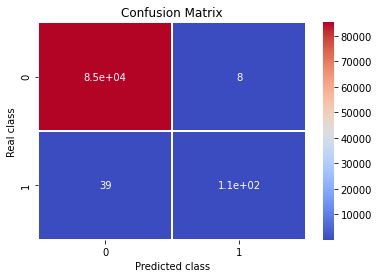

[[85287     8]
 [   39   109]]
accuracy = 0.9994499256814484
precision = 0.9316239316239316
recall = 0.7364864864864865
f1 score = 0.8226415094339623
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.93      0.74      0.82       148

    accuracy                           1.00     85443
   macro avg       0.97      0.87      0.91     85443
weighted avg       1.00      1.00      1.00     85443



In [0]:
xgb_clf = xgb.XGBClassifier(n_jobs = -1, n_estimators = 200)
xgb_clf.fit(X_train, y_train)
y_score = xgb_clf.predict_proba(X_test)[:,1]
y_pred = xgb_clf.predict(X_test)
get_predictions(y_true = y_test, y_pred = y_pred)

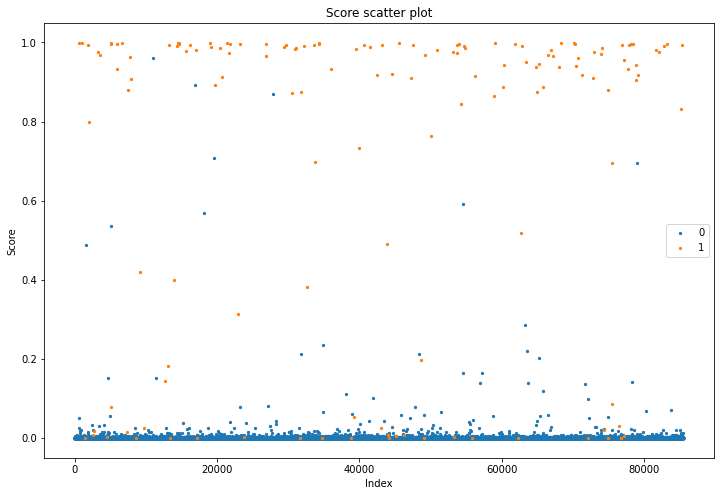

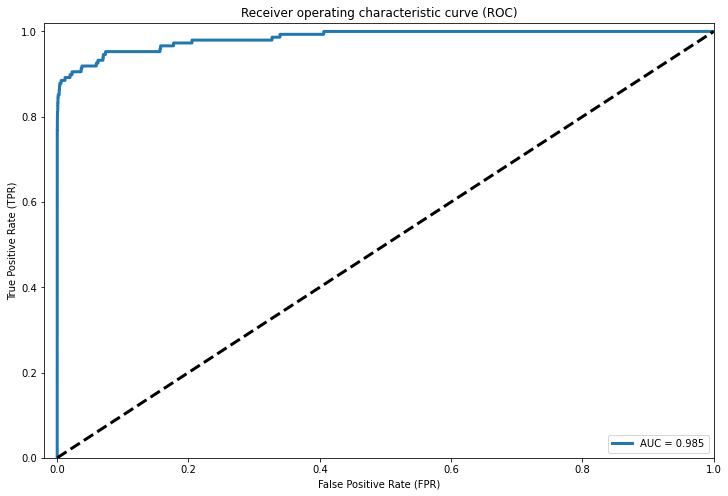

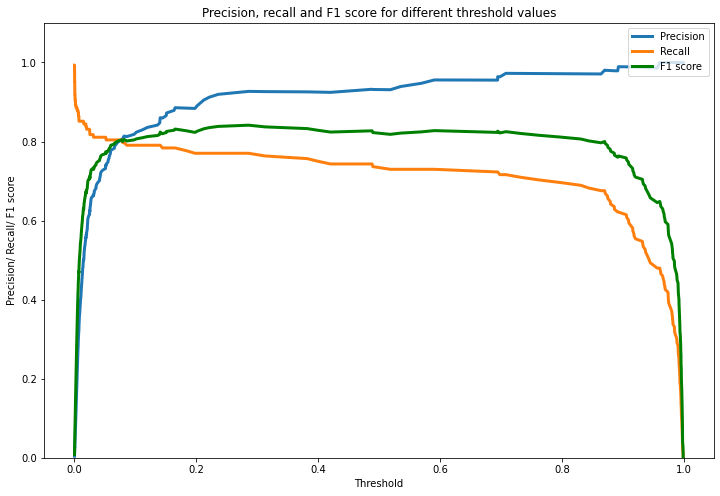

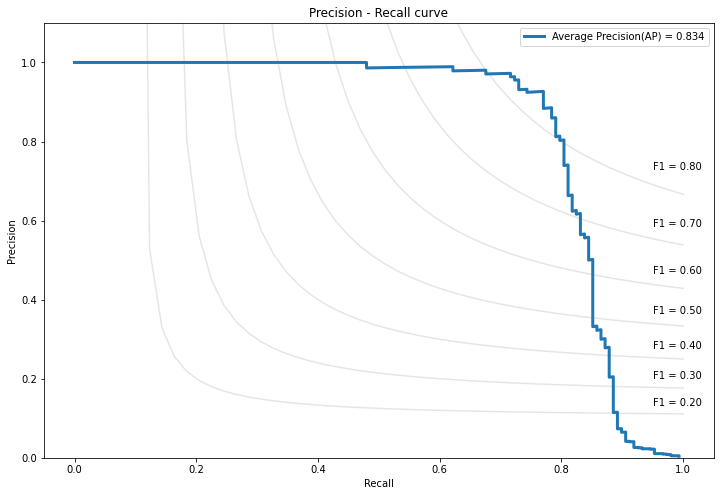

In [0]:
# Plot scores, ROC, Precision, Recall, F1 curve, Precision-Recall curve
C.plot_scores(y_true = y_test, y_score = y_score)
fpr_xgb, tpr_xgb, roc_auc_xgb = C.plot_ROC(y_true = y_test, y_score = y_score)
precision_xgb, recall_xgb, threshold_xgb, f1_scores_xgb = C.plot_precision_recall_vs_threshold(y_true = y_test, y_score = y_score)
_, _, pr_auc_xgb = C.plot_precision_recall(y_true = y_test, y_score = y_score)

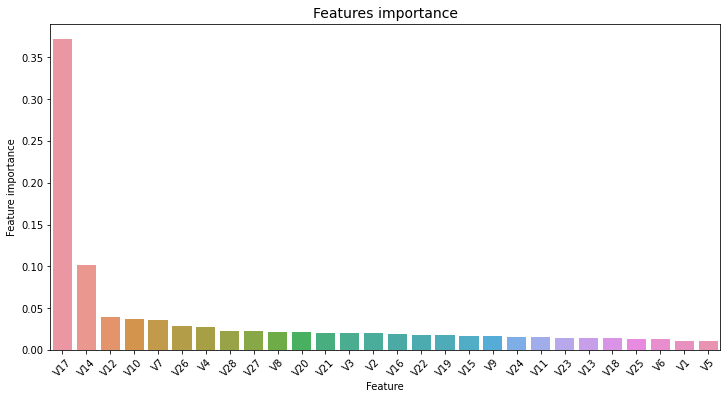

In [0]:
plot_feature_importance(model = xgb_clf, predictors = predictor_name)

### 2.2 Grid Search CV to optimise 'average_precision'

In [0]:
# Applying Grid Search to find the best model and the best parameters
classifier = xgb.XGBClassifier()
parameter = [{'n_estimators': [100, 200, 300, 400]}]

skf = StratifiedKFold(n_splits = 5, random_state = 0)
grid_search = GridSearchCV(estimator = classifier, 
                           param_grid = parameter,
                           scoring = 'f1',
                           cv = skf.split(X_train, y_train),
                           n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)
best_score = grid_search.best_score_
best_parameters = grid_search.best_params_
results = grid_search.cv_results_
best_parameters

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'n_estimators': 400}

### 2.3 XGB with best parameters

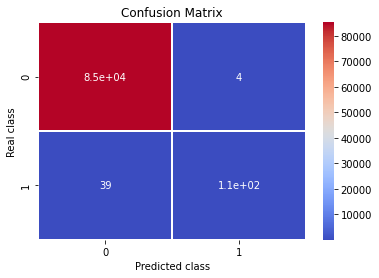

[[85291     4]
 [   39   109]]
accuracy = 0.9994967405170698
precision = 0.9646017699115044
recall = 0.7364864864864865
f1 score = 0.8352490421455939
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.96      0.74      0.84       148

    accuracy                           1.00     85443
   macro avg       0.98      0.87      0.92     85443
weighted avg       1.00      1.00      1.00     85443



In [13]:
xgb_clf = xgb.XGBClassifier(n_jobs = -1, n_estimators = 400)
xgb_clf.fit(X_train, y_train)
y_score = xgb_clf.predict_proba(X_test)[:,1]
y_pred = xgb_clf.predict(X_test)
get_predictions(y_true = y_test, y_pred = y_pred)

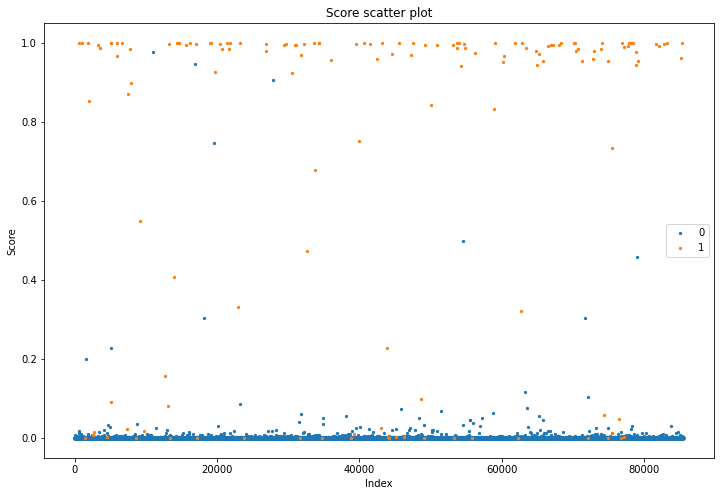

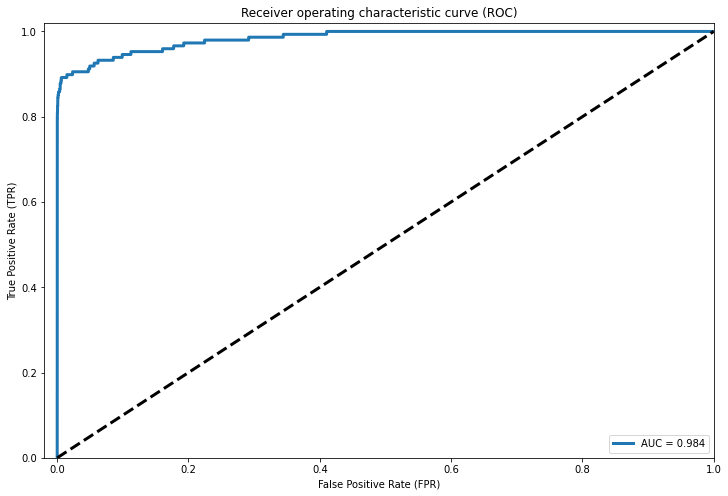

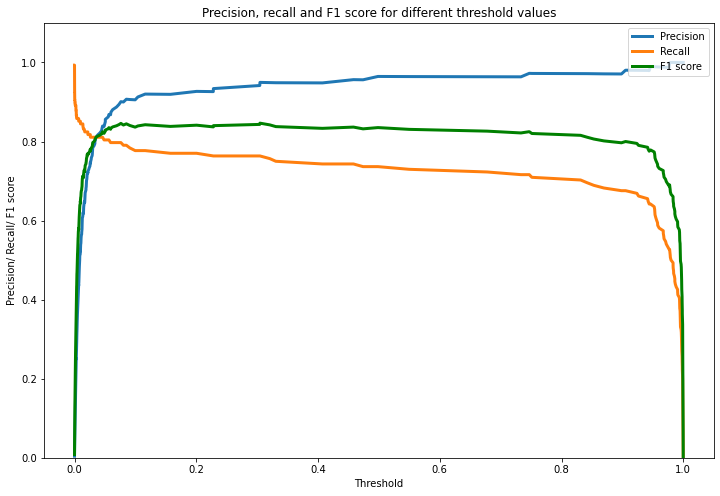

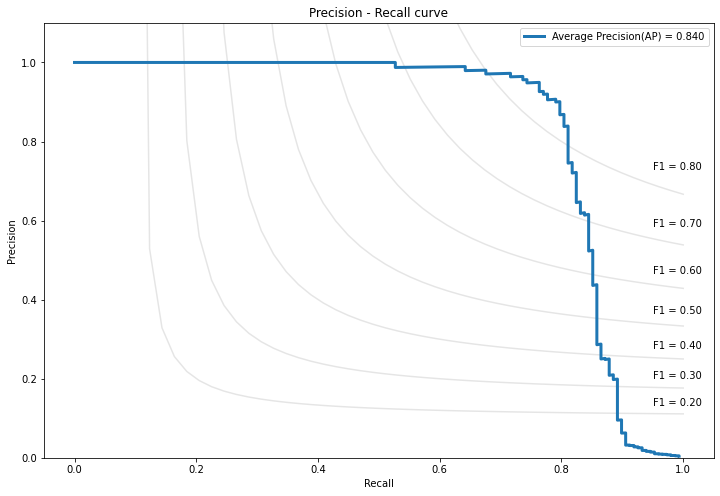

In [14]:
# Plot scores, ROC, Precision, Recall, F1 curve, Precision-Recall curve
C.plot_scores(y_true = y_test, y_score = y_score)
fpr_xgb, tpr_xgb, roc_auc_xgb = C.plot_ROC(y_true = y_test, y_score = y_score)
precision_xgb, recall_xgb, threshold_xgb, f1_scores_xgb = C.plot_precision_recall_vs_threshold(y_true = y_test, y_score = y_score)
_, _, pr_auc_xgb = C.plot_precision_recall(y_true = y_test, y_score = y_score)

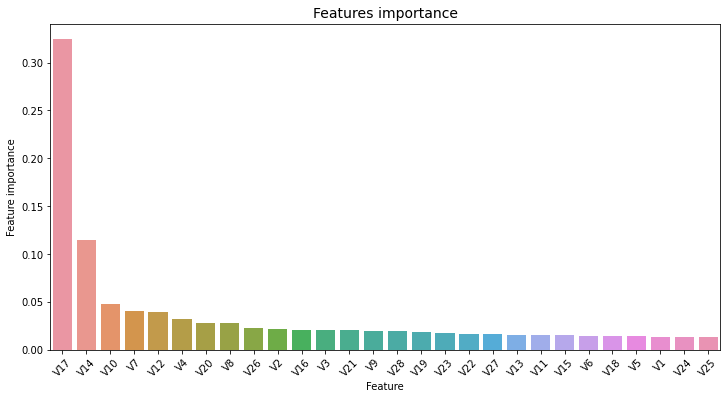

In [15]:
plot_feature_importance(model = xgb_clf, predictors = predictor_name)

## 3. Ramdom forest

### 3.1 Ramdom forest - Without hyperparameters tuning

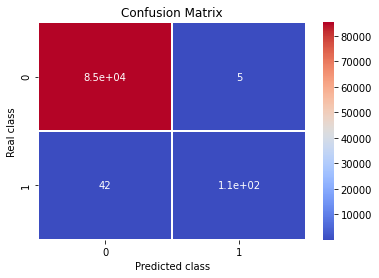

[[85290     5]
 [   42   106]]
accuracy = 0.9994499256814484
precision = 0.954954954954955
recall = 0.7162162162162162
f1 score = 0.8185328185328186
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.95      0.72      0.82       148

    accuracy                           1.00     85443
   macro avg       0.98      0.86      0.91     85443
weighted avg       1.00      1.00      1.00     85443



In [0]:
rf_clf = RandomForestClassifier(n_jobs = -1, random_state = 0)
rf_clf.fit(X_train, y_train)
y_score = rf_clf.predict_proba(X_test)[:,1]
y_pred = rf_clf.predict(X_test)
get_predictions(y_true = y_test, y_pred = y_pred)

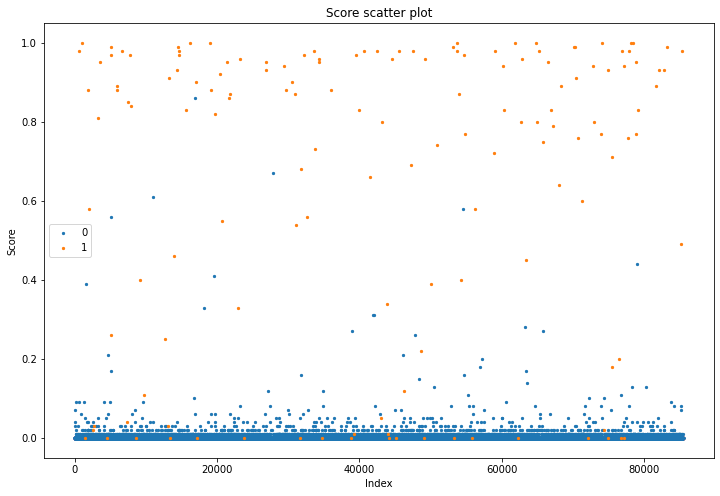

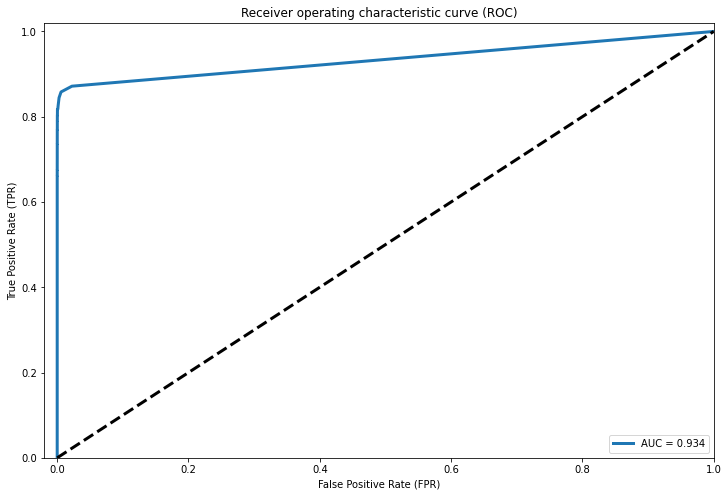

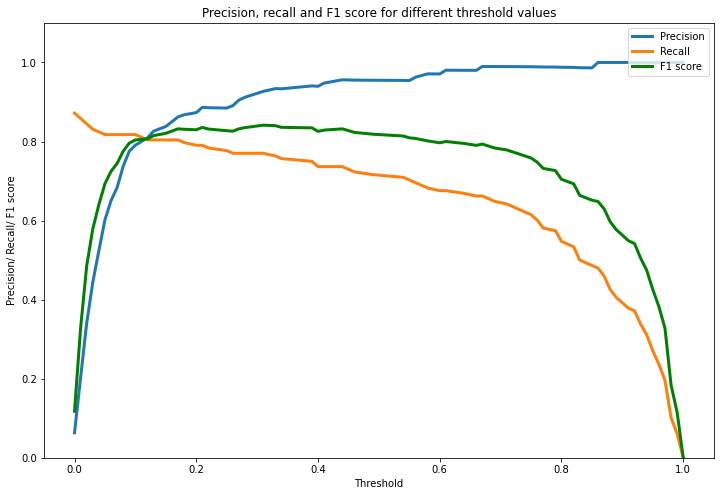

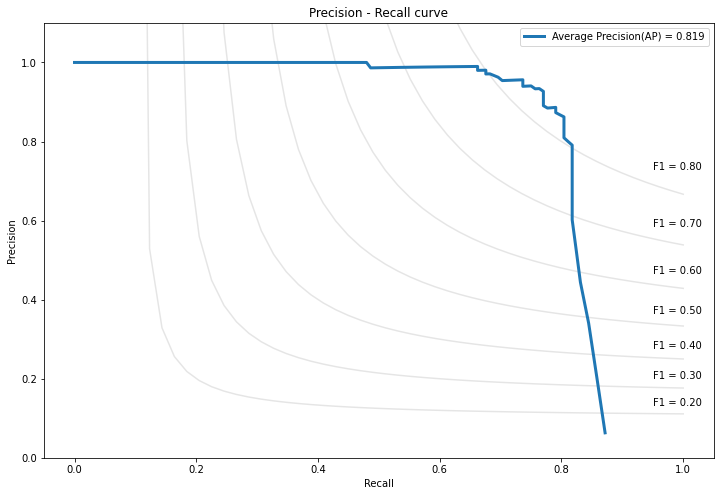

In [0]:
# ## Plot scores, ROC, Precision, Recall, F1 curve, Precision-Recall curve
C.plot_scores(y_true = y_test, y_score = y_score)
fpr_rf, tpr_rf, roc_auc_rf = C.plot_ROC(y_true = y_test, y_score = y_score)
precision_rf, recall_rf, threshold_rf, f1_scores_rf = C.plot_precision_recall_vs_threshold(y_true = y_test, y_score = y_score)
_, _, pr_auc_rf = C.plot_precision_recall(y_true = y_test, y_score = y_score)

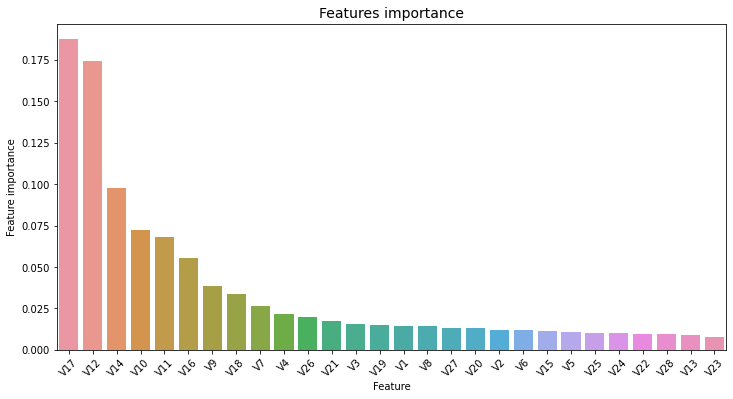

In [0]:
plot_feature_importance(model = rf_clf, predictors = predictor_name)

### 3.2 Grid Search CV to optimise 'average_precision'

In [0]:
# Applying Grid Search to find the best model and the best parameters
classifier = RandomForestClassifier(n_jobs = -1, random_state = 0)
'''
parameter = [{'n_estimators': [100, 200, 300], 
              'max_features': [2, 3], 
              'min_samples_leaf': [1, 2, 4], 
              'min_samples_split': [2, 5, 10]}]
'''
parameter = [{'n_estimators': [100, 200, 300]}]
skf = StratifiedKFold(n_splits = 5, random_state = 0)
grid_search = GridSearchCV(estimator = classifier, 
                           param_grid = parameter,
                           scoring = 'f1',
                           cv = skf.split(X_train, y_train),
                           n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)
best_score = grid_search.best_score_
best_parameters = grid_search.best_params_
results = grid_search.cv_results_
best_parameters

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


{'n_estimators': 200}

### 3.3 Random Forest with best parameters

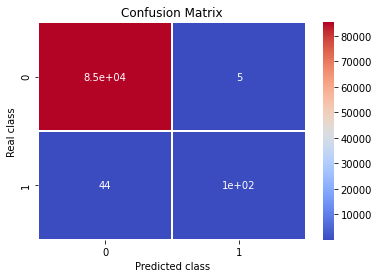

[[85290     5]
 [   44   104]]
accuracy = 0.9994265182636377
precision = 0.9541284403669725
recall = 0.7027027027027027
f1 score = 0.8093385214007782
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.95      0.70      0.81       148

    accuracy                           1.00     85443
   macro avg       0.98      0.85      0.90     85443
weighted avg       1.00      1.00      1.00     85443



In [16]:
rf_clf = RandomForestClassifier(n_estimators = 200, 
                                max_features = 3, 
                                min_samples_leaf = 1, 
                                min_samples_split = 2, 
                                n_jobs = -1,
                                random_state = 0)
rf_clf.fit(X_train, y_train)
y_score = rf_clf.predict_proba(X_test)[:,1]
y_pred = rf_clf.predict(X_test)
get_predictions(y_true = y_test, y_pred = y_pred)

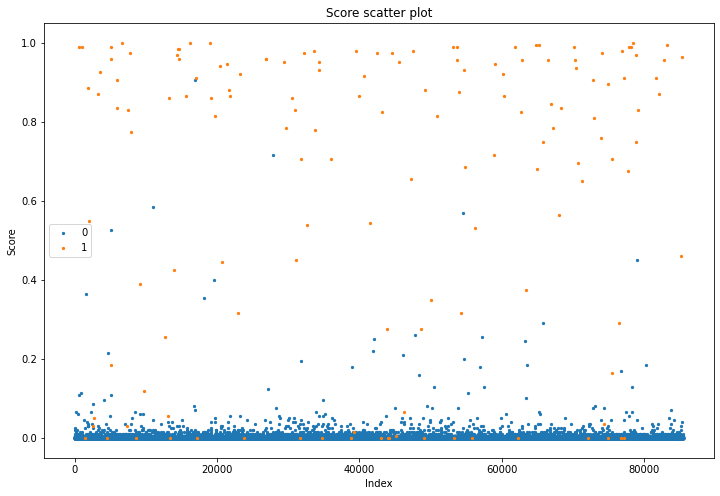

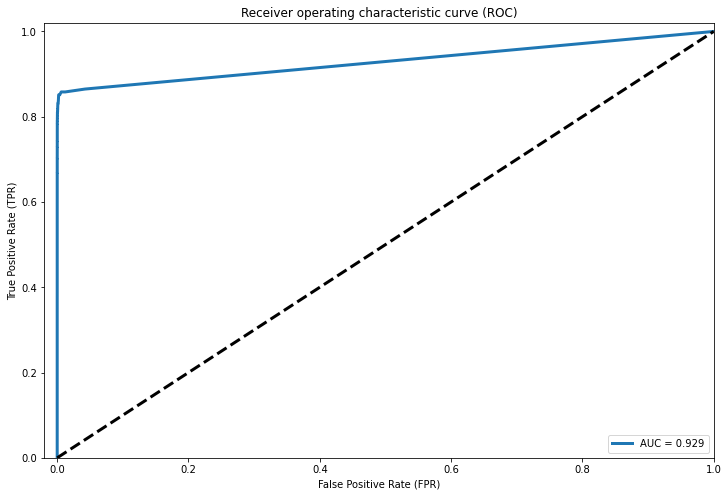

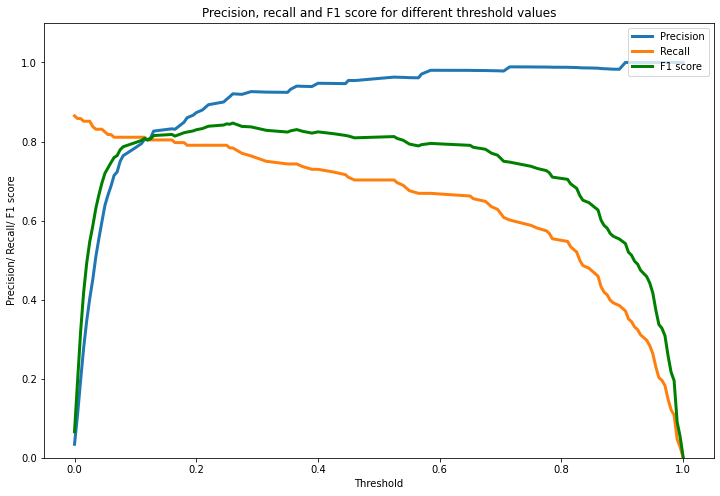

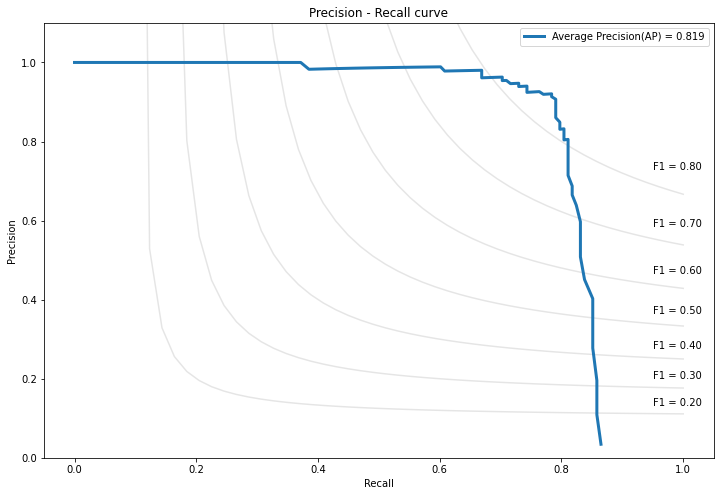

In [17]:
# ## Plot scores, ROC, Precision, Recall, F1 curve, Precision-Recall curve
C.plot_scores(y_true = y_test, y_score = y_score)
fpr_rf, tpr_rf, roc_auc_rf = C.plot_ROC(y_true = y_test, y_score = y_score)
precision_rf, recall_rf, threshold_rf, f1_scores_rf = C.plot_precision_recall_vs_threshold(y_true = y_test, y_score = y_score)
_, _, pr_auc_rf = C.plot_precision_recall(y_true = y_test, y_score = y_score)

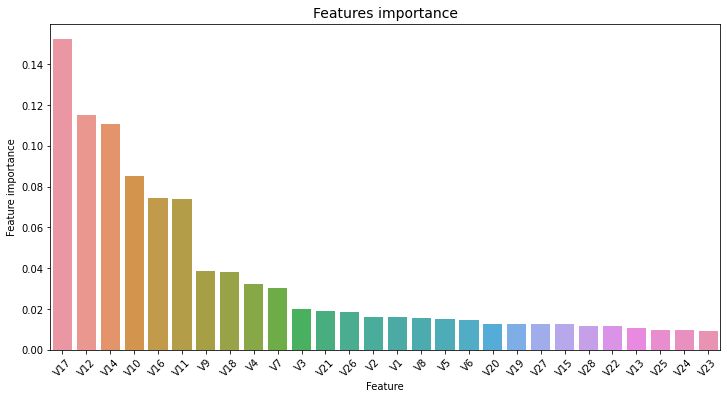

In [18]:
plot_feature_importance(model = rf_clf, predictors = predictor_name)

## 4. CatBoostClassifier

### 4.1 CatBoostClassifier - Without hyperparameters tuning
EX: CatBoostClassifier(loss_function = 'Logloss', eval_metric = 'AUC', learning_rate = 0.1)

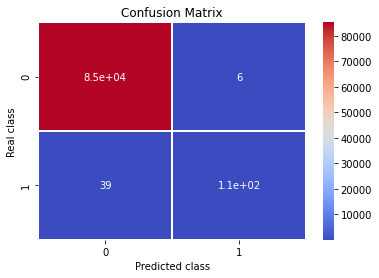

[[85289     6]
 [   39   109]]
accuracy = 0.9994733330992591
precision = 0.9478260869565217
recall = 0.7364864864864865
f1 score = 0.8288973384030419
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.95      0.74      0.83       148

    accuracy                           1.00     85443
   macro avg       0.97      0.87      0.91     85443
weighted avg       1.00      1.00      1.00     85443



In [19]:
# cb_clf = CatBoostClassifier(iterations = 200, learning_rate = 0.5, verbose = 0)
cb_clf = CatBoostClassifier(loss_function = 'Logloss', 
                            eval_metric = 'F1', 
                            learning_rate = 0.1, 
                            iterations = 100, 
                            verbose = 0, 
                            task_type = 'GPU')
cb_clf.fit(X_train, y_train)
y_score = cb_clf.predict_proba(X_test)[:, 1]
y_pred = cb_clf.predict(X_test)
get_predictions(y_true = y_test, y_pred = y_pred)

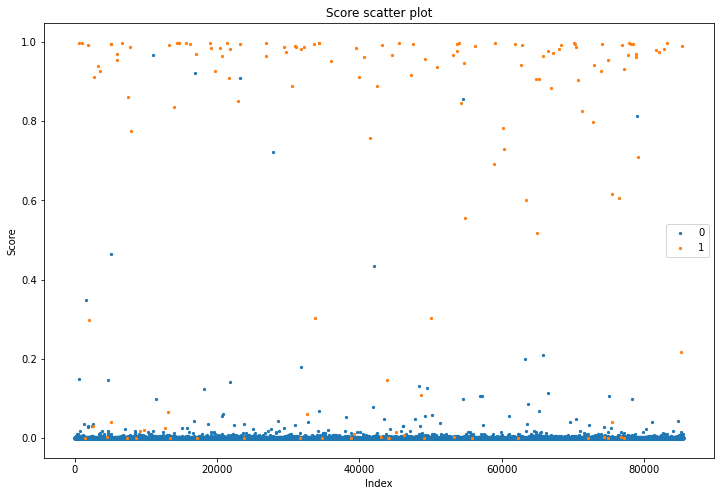

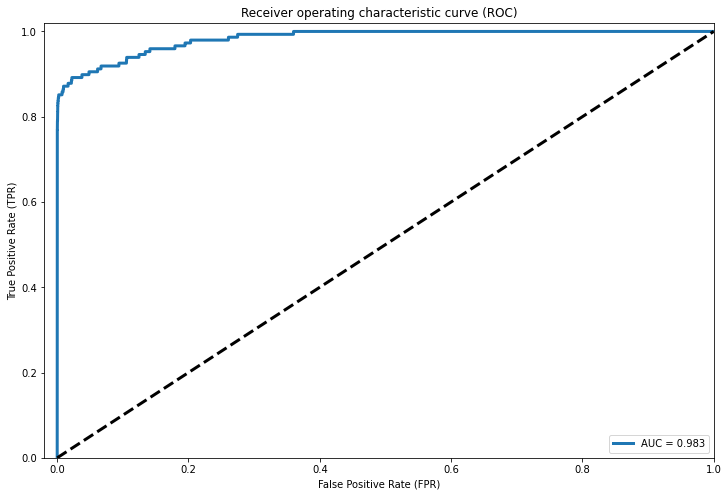

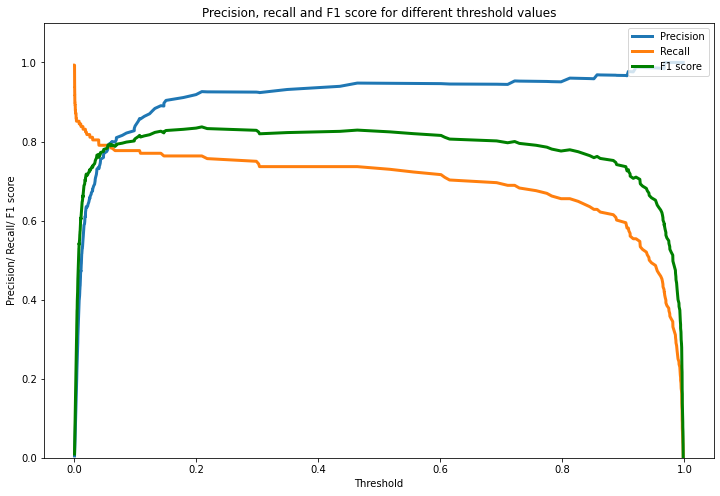

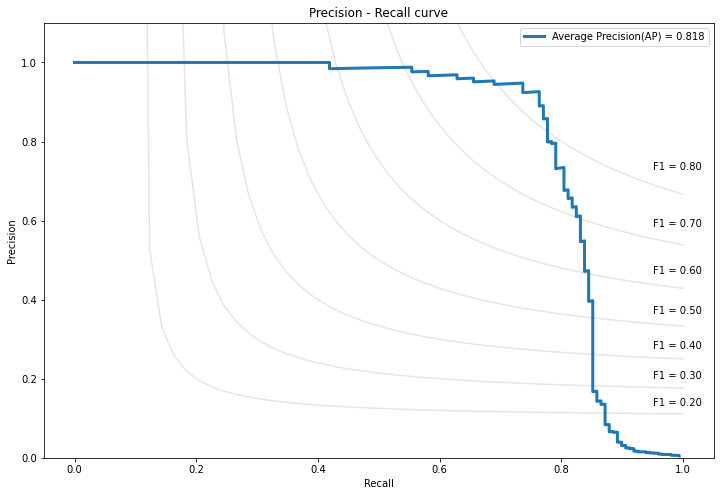

In [20]:
# Plot scores, ROC, Precision, Recall, F1 curve, Precision-Recall curve
C.plot_scores(y_true = y_test, y_score = y_score)
fpr_cb, tpr_cb, roc_auc_cb = C.plot_ROC(y_true = y_test, y_score = y_score)
precision_cb, recall_cb, threshold_cb, f1_scores_cb = C.plot_precision_recall_vs_threshold(y_true = y_test, y_score = y_score)
_, _, pr_auc_cb = C.plot_precision_recall(y_true = y_test, y_score = y_score)

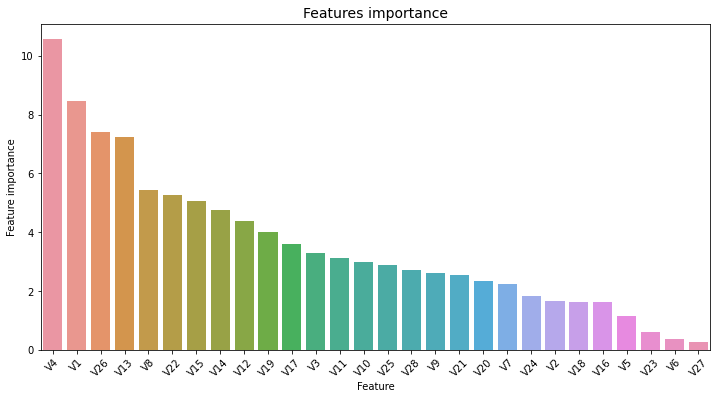

In [21]:
# Plot Feature importance
plot_feature_importance(model = cb_clf, predictors = predictor_name)

### 4.2 Grid Search CV to optimize 'F1'

In [22]:
classifier = CatBoostClassifier(loss_function = 'Logloss', 
                                eval_metric = 'F1', 
                                task_type = 'GPU')
'''
parameter = {'learning_rate': [0.1, 0.5, 1], 
             'iterations': [100],
             'depth': [4],
             'l2_leaf_reg': [1]}
'''
parameter = {'learning_rate': np.arange(0.01, 1, 0.01), 
             'iterations': [50, 100, 200]}
skf = StratifiedKFold(n_splits = 5, random_state = 0)
randomized_search_result = classifier.randomized_search(parameter, 
                                                        X = X_train,
                                                        y = y_train, 
                                                        cv = skf,
                                                        plot = True)
print(randomized_search_result['params'])

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 0.8707483	best: 0.8707483 (0)	total: 7.07s	remaining: 1m 3s
1:	loss: 0.8827586	best: 0.8827586 (1)	total: 12s	remaining: 48.1s
2:	loss: 0.9041096	best: 0.9041096 (2)	total: 16.9s	remaining: 39.5s
3:	loss: 0.8611111	best: 0.9041096 (2)	total: 21.9s	remaining: 32.9s
4:	loss: 0.8979592	best: 0.9041096 (2)	total: 30.3s	remaining: 30.3s
5:	loss: 0.8979592	best: 0.9041096 (2)	total: 38.6s	remaining: 25.8s
6:	loss: 0.8904110	best: 0.9041096 (2)	total: 47.1s	remaining: 20.2s
7:	loss: 0.8888889	best: 0.9041096 (2)	total: 55.6s	remaining: 13.9s
8:	loss: 0.9054054	best: 0.9054054 (8)	total: 1m 10s	remaining: 7.89s
9:	loss: 0.8933333	best: 0.9054054 (8)	total: 1m 26s	remaining: 0us
Estimating final quality...
{'iterations': 200, 'learning_rate': 0.05}


### 4.3 CatBoost with best parameters

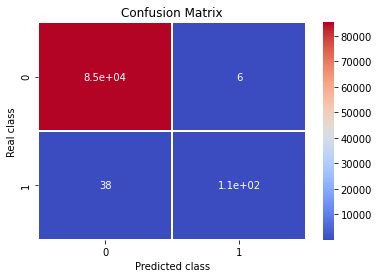

[[85289     6]
 [   38   110]]
accuracy = 0.9994850368081645
precision = 0.9482758620689655
recall = 0.7432432432432432
f1 score = 0.8333333333333333
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.95      0.74      0.83       148

    accuracy                           1.00     85443
   macro avg       0.97      0.87      0.92     85443
weighted avg       1.00      1.00      1.00     85443



In [23]:
cb_clf = CatBoostClassifier(loss_function = 'Logloss', 
                            eval_metric = 'F1',
                            learning_rate = 0.05, 
                            iterations = 200,
                            verbose = 0, 
                            task_type = 'GPU')
cb_clf.fit(X_train, y_train)
y_score = cb_clf.predict_proba(X_test)[:, 1]
y_pred = cb_clf.predict(X_test)
get_predictions(y_true = y_test, y_pred = y_pred)

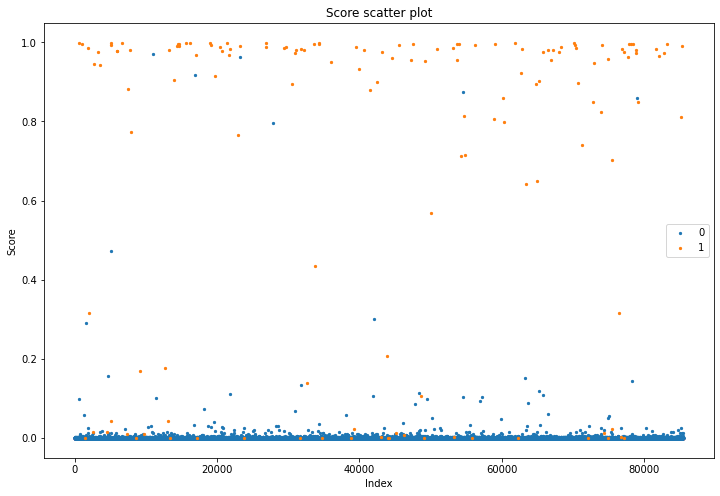

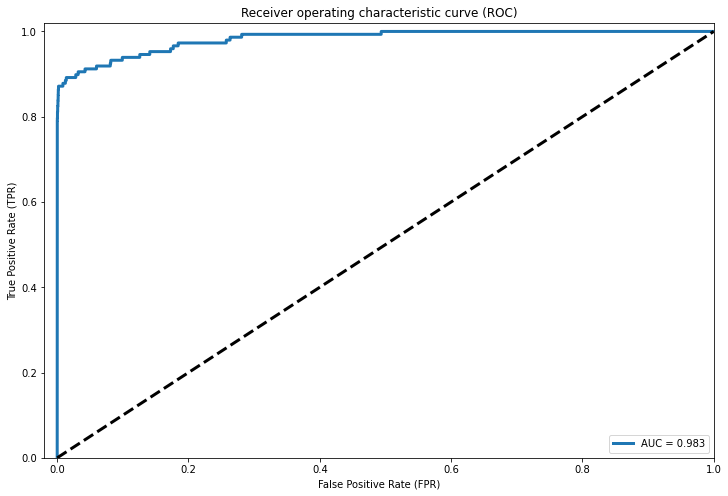

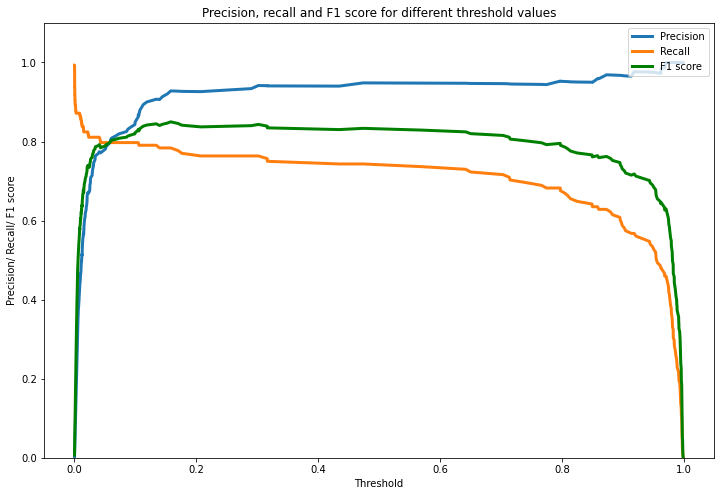

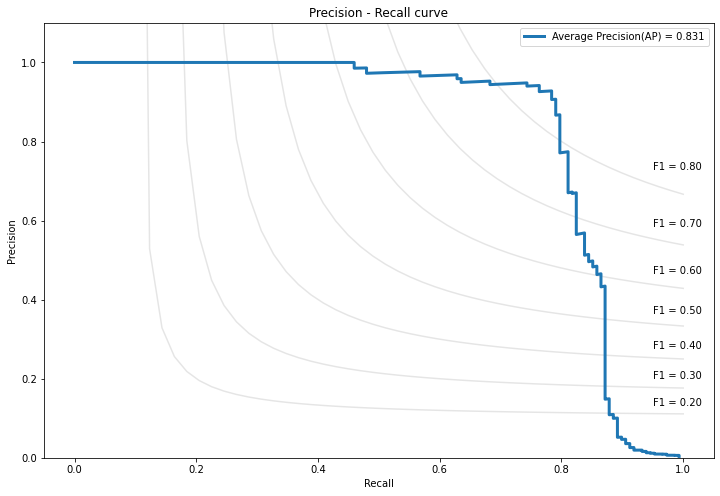

In [24]:
# Plot scores, ROC, Precision, Recall, F1 curve, Precision-Recall curve
C.plot_scores(y_true = y_test, y_score = y_score)
fpr_cb, tpr_cb, roc_auc_cb = C.plot_ROC(y_true = y_test, y_score = y_score)
precision_cb, recall_cb, threshold_cb, f1_scores_cb = C.plot_precision_recall_vs_threshold(y_true = y_test, y_score = y_score)
_, _, pr_auc_cb = C.plot_precision_recall(y_true = y_test, y_score = y_score)

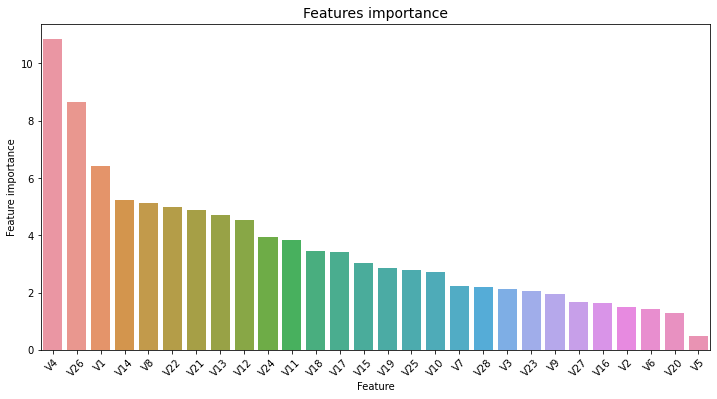

In [25]:
# Plot Feature importance
plot_feature_importance(model = cb_clf, predictors = predictor_name)

## Voting Classifier
Combining classifiers: lr_clf, xgb_clf, rf_clf, cb_clf. 

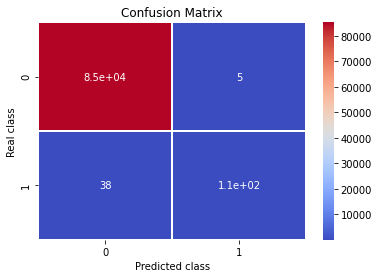

[[85290     5]
 [   38   110]]
accuracy = 0.9994967405170698
precision = 0.9565217391304348
recall = 0.7432432432432432
f1 score = 0.8365019011406843
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.96      0.74      0.84       148

    accuracy                           1.00     85443
   macro avg       0.98      0.87      0.92     85443
weighted avg       1.00      1.00      1.00     85443



In [32]:
lr_clf = LogisticRegression(solver = 'liblinear', random_state = 0)
xgb_clf = xgb.XGBClassifier(n_jobs = -1, n_estimators = 400)
rf_clf = RandomForestClassifier(n_estimators = 200, 
                                max_features = 3, 
                                min_samples_leaf = 1, 
                                min_samples_split = 2, 
                                n_jobs = -1,
                                random_state = 0)
cb_clf = CatBoostClassifier(loss_function = 'Logloss', 
                            eval_metric = 'F1',
                            learning_rate = 0.05, 
                            iterations = 200,
                            verbose = 0, 
                            task_type = 'GPU')
voting_clf = VotingClassifier(estimators = [('lr', lr_clf), ('xgb', xgb_clf), ('rf', rf_clf), ('cb', cb_clf)], 
                              voting = 'soft', 
                              weights = [1, 2, 1, 2])
voting_clf.fit(X_train,y_train)
y_score = voting_clf.predict_proba(X_test)[:,1]
y_pred = voting_clf.predict(X_test)
get_predictions(y_true = y_test, y_pred = y_pred)

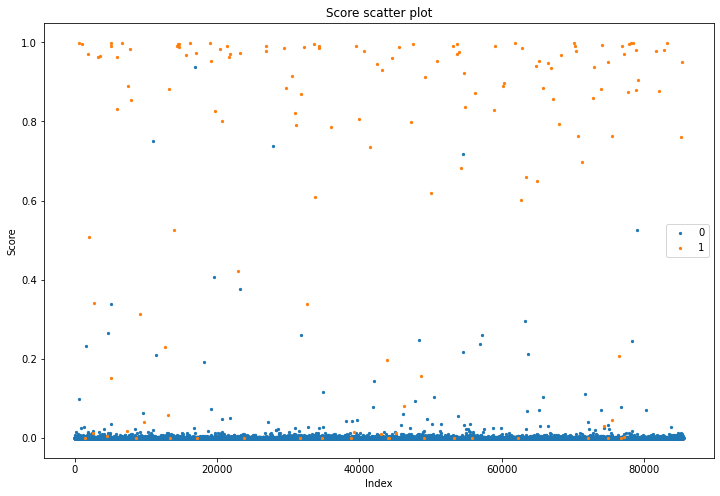

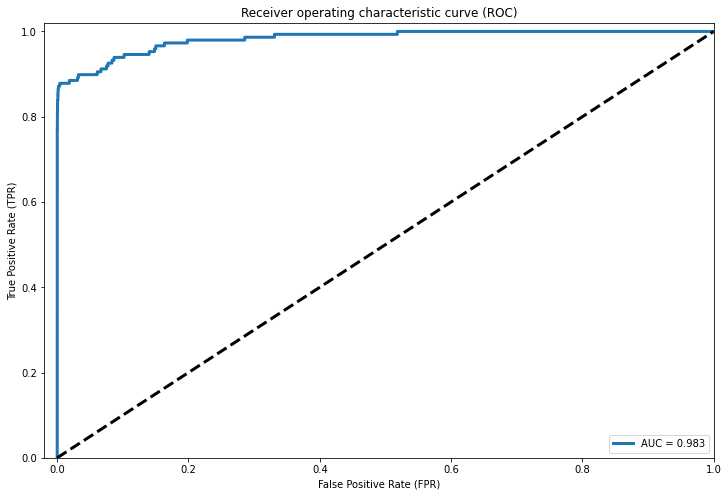

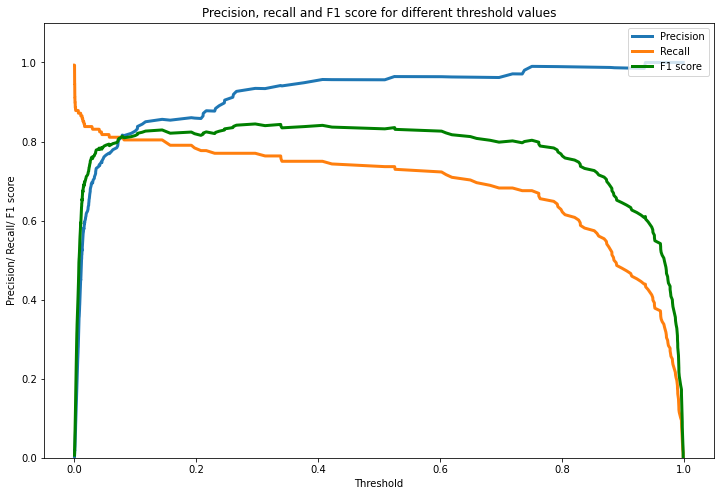

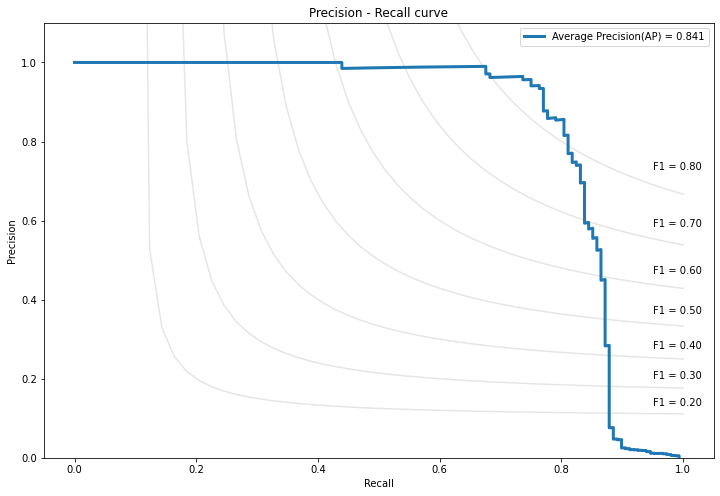

In [33]:
# Plot scores, ROC, Precision, Recall, F1 curve, Precision-Recall curve
C.plot_scores(y_true = y_test, y_score = y_score)
fpr_voting, tpr_voting, roc_auc_voting = C.plot_ROC(y_true = y_test, y_score = y_score)
precision_voting, recall_voting, threshold_voting, f1_scores_voting = C.plot_precision_recall_vs_threshold(y_true = y_test, y_score = y_score)
_, _, pr_auc_voting = C.plot_precision_recall(y_true = y_test, y_score = y_score)

In [0]:
def roc_curve_for_all_models():
    plt.figure(figsize = (12, 8))
    plt.plot(fpr_lr, tpr_lr, label = 'LogisticRegression: AUC = {:.4f}'.format(roc_auc_lr), linewidth = 2)
    plt.plot(fpr_xgb, tpr_xgb, label = 'XGBoost: AUC = {:.4f}'.format(roc_auc_xgb), linewidth = 2)
    plt.plot(fpr_rf, tpr_rf, label = 'Random Forest: AUC = {:.4f}'.format(roc_auc_rf), linewidth = 2)
    plt.plot(fpr_cb, tpr_cb, label = 'CatBoost: AUC = {:.4f}'.format(roc_auc_cb), linewidth = 2)    
    plt.plot(fpr_voting, tpr_voting, label = 'VotingClassifier: AUC = {:.4f}'.format(roc_auc_voting), linewidth = 2)
    plt.plot([0, 1], [0, 1], 'k--', linewidth = 2)
    plt.xlim([-0.05, 1])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate(FPR)')
    plt.ylabel('True Positive Rate(TPR)')
    plt.title('Receiver operating characteristic curve (ROC)')
    plt.legend(loc = 'lower right')
    plt.savefig('roc.png')
    plt.show()

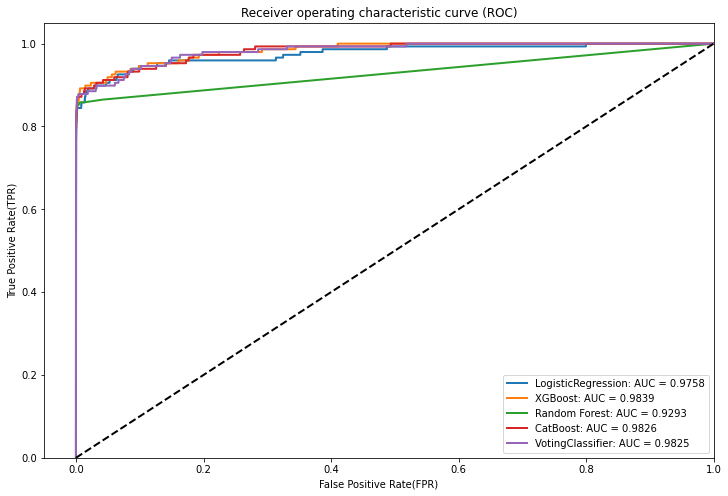

In [35]:
roc_curve_for_all_models()

In [0]:
def precision_recall_for_all_models () :
    plt.figure(figsize = (12, 8))
    f_scores = np.linspace(0.2, 0.8, num = 4)
    for f_score in f_scores:
        x = np.linspace(0.001, 1)
        y = f_score * x / (2 * x - f_score)
        plt.plot(x[y >= 0], y[y >= 0], color = 'gray', alpha = 0.2)
        plt.annotate('F1 = {:.2f}'.format(f_score), xy = (0.92, y[45] + 0.02))

    plt.plot(recall_lr, precision_lr, label = 'LogisticRegression: AUC = {:.4f}'.format(pr_auc_lr), linewidth = 2)
    plt.plot(recall_xgb, precision_xgb, label = 'XGBoost: AUC = {:.4f}'.format(pr_auc_xgb), linewidth = 2)
    plt.plot(recall_rf, precision_rf, label = 'Random Forest: AUC = {:.4f}'.format(pr_auc_rf), linewidth = 2)
    plt.plot(recall_cb, precision_cb, label = 'CatBoost: AUC = {:.4f}'.format(pr_auc_cb), linewidth = 2)
    plt.plot(recall_voting, precision_voting, label = 'VotingClassifier: AUC = {:.4f}'.format(pr_auc_voting), linewidth = 2)
    plt.xlim([0.0, 1])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision - Recall Curve')
    plt.legend(loc = 'lower left')
    plt.savefig('precision_recall.png')
    plt.show()

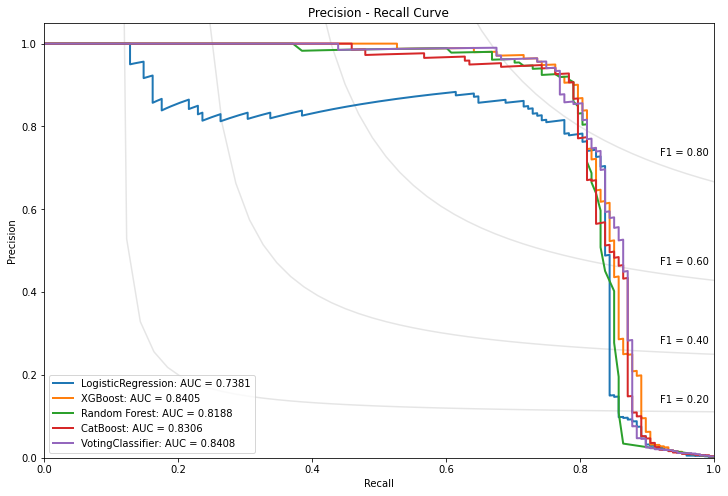

In [37]:
precision_recall_for_all_models() 